<a href="https://colab.research.google.com/github/metaute73/Proyecto-Gen-mica-2024-2/blob/main/Avances_19_de_Febrero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# **Preprocesamiento para quitar Outliers con Medianas**

In [43]:
def process_genomic_data(csv_file, visualizar):
    """
    Carga un archivo CSV, filtra los datos, elimina valores atípicos usando MAD en 'Depth' y genera visualizaciones.

    Parámetros:
        csv_file (str): Ruta del archivo CSV.

    Retorna:
        pd.DataFrame: DataFrame procesado.
    """
    # Configurar estilo de gráficos
    plt.style.use('ggplot')
    sns.set_style("whitegrid")

    # Cargar datos
    df = pd.read_csv(csv_file, delimiter="\t")
    antes = len(df)
    # Filtrar por longitud mínima
    df = df[df['Length'] >= 1000]

    # Eliminar valores atípicos en 'Depth' usando el método MAD
    median_depth = df['Depth'].median()
    MAD = np.median(np.abs(df['Depth'] - median_depth))
    threshold_mad = 4 * MAD
    lower_bound_mad = median_depth - threshold_mad
    upper_bound_mad = median_depth + threshold_mad
    df = df[(df['Depth'] >= lower_bound_mad) & (df['Depth'] <= upper_bound_mad)]
    despues = len(df)
    # Graficar distribuciones
    if visualizar:
      fig, axes = plt.subplots(2, 2, figsize=(12, 10))

      sns.histplot(df["Length"], bins=20, kde=True, color="seagreen", ax=axes[0, 0])
      axes[0, 0].set_title("Distribución de la Longitud de los Scaffolds")

      sns.histplot(df["GC"], bins=20, kde=True, ax=axes[0, 1])
      axes[0, 1].set_title("Distribución del contenido GC")

      sns.histplot(df["Depth"], bins=20, kde=True, color="orange", ax=axes[1, 0])
      axes[1, 0].set_title("Distribución de la Profundidad de los Scaffolds")

      sns.histplot(df["AltAllels"], bins=10, kde=True, color="cyan", ax=axes[1, 1])
      axes[1, 1].set_title("Distribución de los Alelos Alternativos")

      plt.tight_layout()
      plt.show()

      # Ajustar el número de grupos para evitar desajustes con la paleta
      num_groups = min(len(df), 5)  # Máximo 6 grupos, pero limitado al tamaño de df
      df = df.sort_values(by='Length', ascending=False)
      df['Scaffold group'] = np.repeat(range(1, num_groups + 1), np.ceil(len(df) / num_groups))[:len(df)]
      custom_palette = sns.color_palette("viridis", num_groups)

      # Graficar pairplot
      g = sns.pairplot(
          df,
          diag_kind="kde",
          vars=['Length', 'GC', 'Depth', 'AltAllels'],
          hue='Scaffold group',
          palette=custom_palette
      )

      g._legend.remove()
      plt.show()

      # Graficar Length vs Depth
      sns.scatterplot(x='Depth', y='Length', data=df, hue='Scaffold group', palette=custom_palette)
      plt.xlabel('Depth')
      plt.ylabel('Length')
      plt.title('Length vs Depth')
      plt.show()

      # Calcular el total de AltAllels
      #print(f"Total de Alelos Alternativos: {total_altallels}")
    total_altallels = df["AltAllels"].sum()
    return df, antes-despues, total_altallels

# **N50**

In [46]:
def calcular_n50(df):
    df_sorted = df.sort_values(by='Length', ascending=False)
    total_length = df_sorted['Length'].sum()
    half_length = total_length / 2

    cumulative_length = 0
    for length in df_sorted['Length']:
        cumulative_length += length
        if cumulative_length >= half_length:
            return length

# **Mezcla de Gaussianas**

In [101]:
def mezcla_de_gaussianas(df, n):
    """
    Genera visualizaciones de 2 o más distribuciones gaussianas de la distribución conjunta de Depth y Length.
    Normaliza los datos antes del ajuste del modelo y los devuelve en su escala original al final.

    Parámetros:
        df (pandas.DataFrame): DataFrame del experimento
        n : Número de gaussianas a ajustar en el modelo.

    Retorna:
        pandas.DataFrame: DataFrame con la clasificación de gaussianas y datos en su escala original.
    """
    from sklearn.mixture import GaussianMixture
    from sklearn.preprocessing import StandardScaler
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Normalizar los datos
    scaler = StandardScaler()
    df[['Depth', 'Length']] = scaler.fit_transform(df[['Depth', 'Length']])

    X = df[['Depth', 'Length']].dropna().values

    # Aplicar el modelo de mezcla de gaussianas
    gmm = GaussianMixture(n_components=n, covariance_type='tied', random_state=13)
    gmm.fit(X)

    labels = gmm.predict(X)
    df.loc[df[['Depth', 'Length']].dropna().index, 'gaussian'] = labels
    df["gaussian"] = df["gaussian"].astype(int)


    # Gráfica de dispersión
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df["Depth"], y=df["Length"], hue=df["gaussian"], palette="viridis", alpha=0.9)
    plt.xlabel("Depth")
    plt.ylabel("Length")
    plt.title("Fitting Gaussian Mixture Model to Depth vs Length")

    # Mapa de contorno
    x_min, x_max = df["Depth"].min(), df["Depth"].max()
    y_min, y_max = df["Length"].min(), df["Length"].max()
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    xy_sample = np.column_stack([x.ravel(), y.ravel()])
    z = -gmm.score_samples(xy_sample).reshape(x.shape)

    plt.contour(x, y, z, levels=10, linewidths=1.5, colors='black', alpha=0.7)
    plt.show()

    df[['Depth', 'Length']] = scaler.inverse_transform(df[['Depth', 'Length']])


    return df


# **Longitud Máxima**

In [38]:
def max_depth(df):
  return df["Length"].max()

# **Segunda Longitud Máxima**

In [53]:
def segunda_maxima(df):
  return df.nlargest(2, 'Length')['Length'].iloc[1]

# **Diferencia de longitudes máximas en profundidad**

In [56]:
def depth_difference(df, length1, length2):
    depth1 = df.loc[df['Length'] == length1, 'Depth'].values[0]
    depth2 = df.loc[df['Length'] == length2, 'Depth'].values[0]
    return abs(depth1 - depth2)

# **Acumulación de longitudes según su profundidad**

In [60]:
def acumular_longitudes(df, bins):

  num_bins = bins
  depth_bins = np.linspace(df["Depth"].min(), df["Depth"].max(), num_bins)
  bin_centers = (depth_bins[:-1] + depth_bins[1:]) / 2
  df['Depth_bin'] = pd.cut(df['Depth'], bins=depth_bins, labels=bin_centers)

  # Calcular el total de Length en cada bin de Depth
  binned_data = df.groupby(['Depth_bin', 'gaussian'])['Length'].sum().reset_index()
  binned_data['Depth_bin'] = binned_data['Depth_bin'].astype(float)

  # Graficar los datos binned como un bar plot con colores según la clase
  plt.figure(figsize=(8,6))
  classes = binned_data['gaussian'].unique()
  colors = sns.color_palette("viridis", len(classes))
  for g, color in zip(classes, colors):
    subset = binned_data[binned_data['gaussian'] == g]
    plt.bar(subset['Depth_bin'], subset['Length'], width=np.diff(depth_bins).mean(), color=color, alpha=0.6, label=f"Class {g}")

  # Etiquetas y título
  plt.xlabel("Depth (Binned)")
  plt.ylabel("Summed Length in Bin")
  plt.title("Binned Depth vs Summed Length (Bar Plot) by Class")
  plt.legend()
  plt.grid(True)
  plt.show()

# **EJEMPLOS**

## **Visualización Alelos Alternos**

Aquí visualizamos qué scaffolds contienen la mayor cantidad de alelos alternativos (si no son muy largos no deberían importar tanto en la métrica de contaminación)

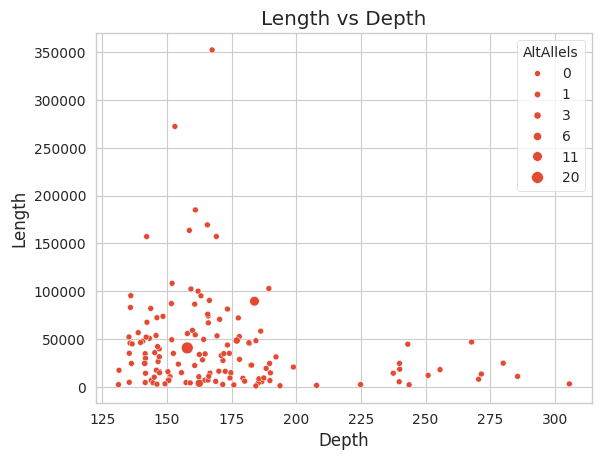

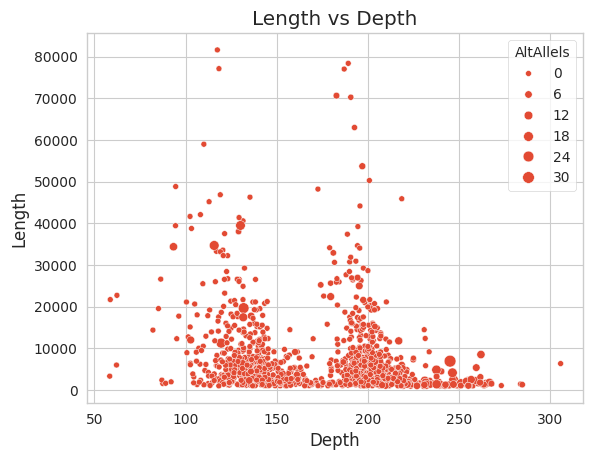

In [143]:
processing = process_genomic_data('/content/sample_data/LengthDepth_14.csv', False)
df = processing[0]

sns.scatterplot(x='Depth', y='Length', data=df, size = 'AltAllels')
plt.xlabel('Depth')
plt.ylabel('Length')
plt.title('Length vs Depth')
plt.show()

processing2 = process_genomic_data('/content/sample_data/LengthDepth_36.csv', False)
df2 = processing2[0]

sns.scatterplot(x='Depth', y='Length', data=df2, size = 'AltAllels')
plt.xlabel('Depth')
plt.ylabel('Length')
plt.title('Length vs Depth')
plt.show()



## **Visualización Mezcla de Gaussianas**

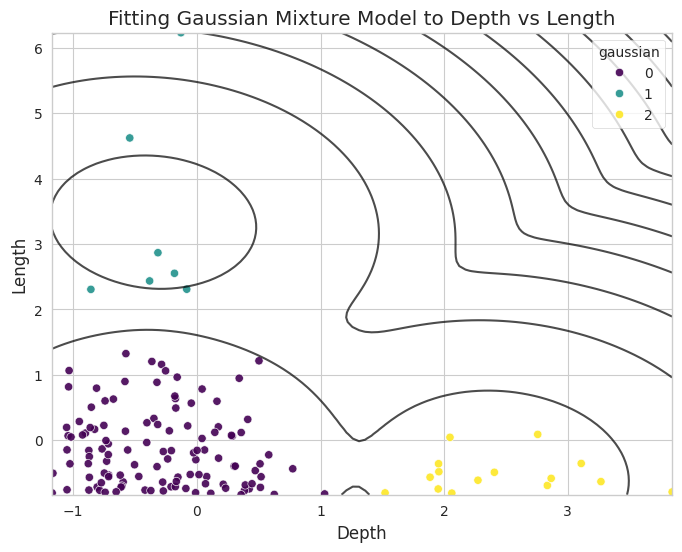

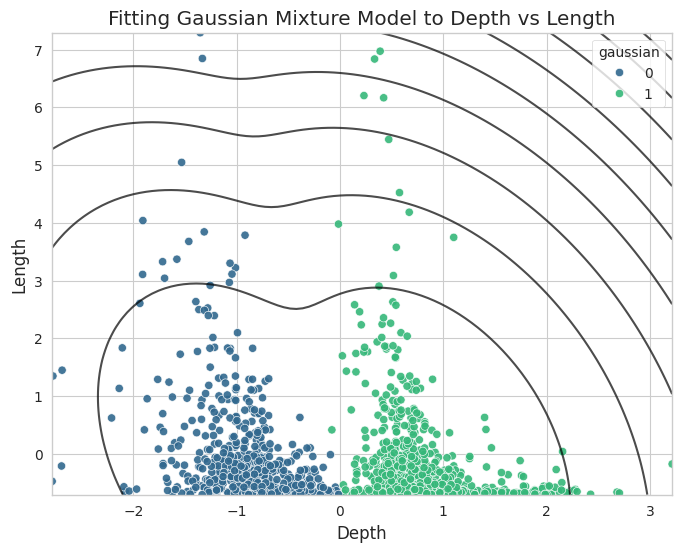

In [144]:
df = mezcla_de_gaussianas(df, 3)

df2 = mezcla_de_gaussianas(df2,2)

## **Visualización de longitudes acumuladas**

<ipython-input-60-826294a4c7e2>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby(['Depth_bin', 'gaussian'])['Length'].sum().reset_index()


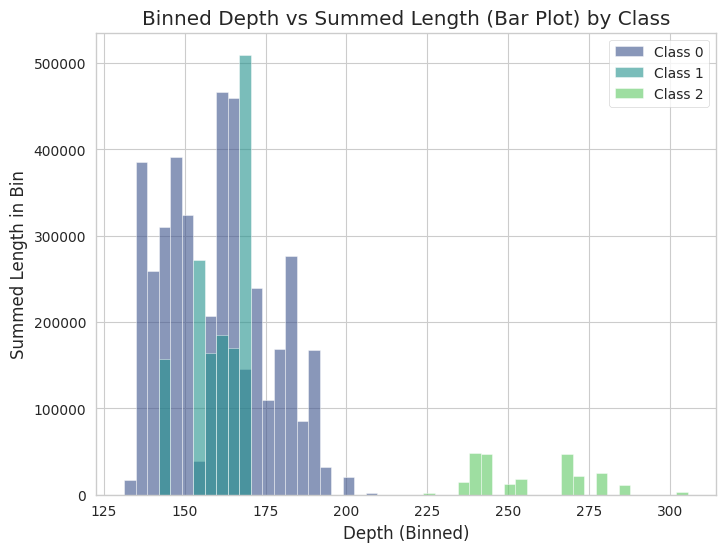

<ipython-input-60-826294a4c7e2>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby(['Depth_bin', 'gaussian'])['Length'].sum().reset_index()


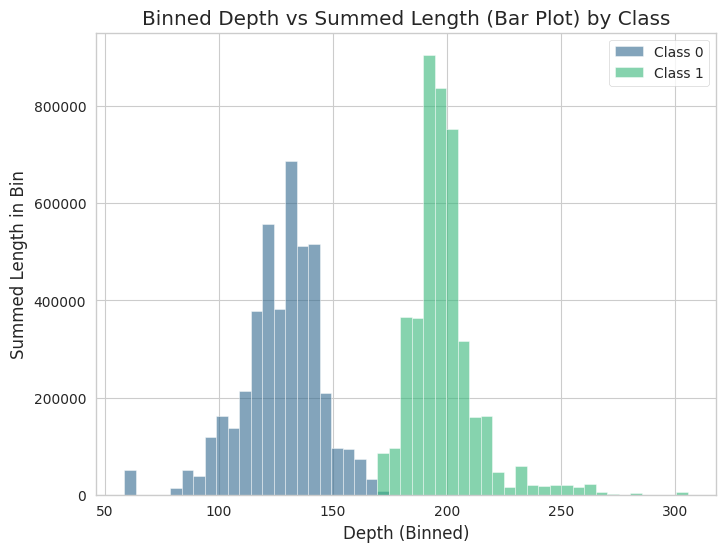

In [145]:
acumular_longitudes(df,50)

acumular_longitudes(df2,50)

# **Resumen Medidas**

In [146]:
# Crear un diccionario con los datos de ejemplo
data = {
    "número de datos": [],
    "número de datos eliminados": [],
    "alelos alternativos": [],
    "N50": [],
    "longitud máxima": [],
    "segunda longitud máxima": [],
    "diferencia de profundidades longitudes máximas": [],
    "suma de longitudes": []
}

for i in range(1,37):
  processing = process_genomic_data(f"/content/sample_data/LengthDepth_{i}.csv", False)
  df = processing[0]
  data["número de datos"].append(len(df))
  data["número de datos eliminados"].append(processing[1])
  data["alelos alternativos"].append(processing[2])
  data["N50"].append(int(calcular_n50(df)))
  data["longitud máxima"].append(int(max_depth(df)))
  data["segunda longitud máxima"].append(int(segunda_maxima(df)))
  data["diferencia de profundidades longitudes máximas"].append(depth_difference(df, max_depth(df), segunda_maxima(df)))
  data["suma de longitudes"].append(int(df['Length'].sum()))
# Crear el DataFrame
df = pd.DataFrame(data)
df.index = df.index + 1
# Mostrar el DataFrame
df.head(36)

,número de datos,número de datos eliminados,alelos alternativos,N50,longitud máxima,segunda longitud máxima,diferencia de profundidades longitudes máximas,suma de longitudes
1,61,35,23,244542,651345,516894,38.4600,5248221
2,313,96,106,55811,259248,174760,53.6320,6933881
3,163,72,46,96398,488560,224831,19.1530,6846435
4,412,178,74,32257,162571,143408,13.1560,6586733
5,121,57,61,155639,375220,367619,21.1780,6913327
6,185,84,75,73385,259472,206226,8.0210,6798117
7,90,30,60,174294,367366,365868,18.7610,6781048
8,381,127,94,36569,143390,130525,5.1510,6613630
9,89,36,9,160121,894069,705447,12.1240,6036229
10,55,18,0,235425,968665,500537,48.9440,5752687
